<h1>Lab Three: Extending Logistic Regression</h1>
<b>By Michael Watts, Maya Muralidhar, Nora Potenti, and Adam Ashcraft </b>

# 1.0 Business Understanding

This dataset is from the Free Music Archive, a collection of legally available audio files.  The numerical data is made up of features extracted from a musical analysis python package called librosa that quantifies some of the characteristics of an mp3 and also includes statistics such as mean, skew, and kurtosis.  The dataset also includes unique codes for genres of music.  We will use these features to determine what the genre of a piece is given the librosa feature extraction.  This classification would prove useful for a music streaming application such as Spotify that would want to integrate new music into its platform quickly, especially if the defined genre in the audio file's metadata doesn't matches one of the genres defined in the application's database. It would also help with the application's recommendation system; by broadly defining the main genre categories, users could receive recommendations that are audibly similar. For this use case, the model would be deployed to a production. To measure our success, we will compare our results to the International Society for Music Information Retrieval’s Music Information Retrieval Evaluation eXchange (MIREX) 2017 competition winning algorithm LPNKK1, which has an accuracy of approximately 77%. Our algorithm is considered a success if it can outperform this academic algorithm’s genre classification success rate.
<hr>
Data Set Source: https://github.com/mdeff/fma <br>
MIREX Competition Results: http://www.music-ir.org/nema_out/mirex2017/results/act/mixed_report/summary.html

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import pickle
import warnings
from sklearn.metrics import accuracy_score

In [5]:
feature_df = pd.read_csv("data/features.csv", skiprows=range(1,4))
feature_df.rename(columns={'feature':'track_id'}, inplace=True)
genre_df = pd.read_csv("data/genres.csv")
track_df = pd.read_csv("data/tracks.csv", skiprows=[0,2])
track_df.rename(columns={'Unnamed: 0':'track_id'}, inplace=True)
feature_df.head()

,track_id,chroma_cens,chroma_cens.1,chroma_cens.2,chroma_cens.3,chroma_cens.4,chroma_cens.5,chroma_cens.6,chroma_cens.7,chroma_cens.8,...,tonnetz.39,tonnetz.40,tonnetz.41,zcr,zcr.1,zcr.2,zcr.3,zcr.4,zcr.5,zcr.6
0,2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
2,5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
3,10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
4,20,-0.193837,-0.198527,0.201546,0.258556,0.775204,0.084794,-0.289294,-0.816410,0.043851,...,0.095003,0.022492,0.021355,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993


In [6]:
genre_df.head()

,genre_id,#tracks,parent,title,top_level
0,1,8693,38,Avant-Garde,38
1,2,5271,0,International,2
2,3,1752,0,Blues,3
3,4,4126,0,Jazz,4
4,5,4106,0,Classical,5


In [7]:
track_df.columns

Index(['track_id', 'comments', 'date_created', 'date_released', 'engineer',
       'favorites', 'id', 'information', 'listens', 'producer', 'tags',
       'title', 'tracks', 'type', 'active_year_begin', 'active_year_end',
       'associated_labels', 'bio', 'comments.1', 'date_created.1',
       'favorites.1', 'id.1', 'latitude', 'location', 'longitude', 'members',
       'name', 'related_projects', 'tags.1', 'website', 'wikipedia_page',
       'split', 'subset', 'bit_rate', 'comments.2', 'composer',
       'date_created.2', 'date_recorded', 'duration', 'favorites.2',
       'genre_top', 'genres', 'genres_all', 'information.1', 'interest',
       'language_code', 'license', 'listens.1', 'lyricist', 'number',
       'publisher', 'tags.2', 'title.1'],
      dtype='object')

In [8]:
track_df[['genre_top', 'genres']].head()

,genre_top,genres
0,Hip-Hop,[21]
1,Hip-Hop,[21]
2,Hip-Hop,[21]
3,Pop,[10]
4,NaN,"[76, 103]"


In [9]:
top_ten_genres = genre_df.sort_values(by='#tracks', ascending=False)[:10]
top_ten_genres

,genre_id,#tracks,parent,title,top_level
31,38,38154,0,Experimental,38
14,15,34413,0,Electronic,15
11,12,32923,0,Rock,12
162,1235,14938,0,Instrumental,1235
9,10,13845,0,Pop,10
16,17,12706,0,Folk,17
22,25,9261,12,Punk,12
0,1,8693,38,Avant-Garde,38
20,21,8389,0,Hip-Hop,21
27,32,7268,38,Noise,38


We'll only look at the top ten genres listed and, if the track's top genre is in this list, include that track in our reduced dataframe.

In [10]:
track_df = track_df[track_df['genre_top'].isin(top_ten_genres['title'].values)]
track_df['genre_top'].value_counts()

Rock            14182
Experimental    10608
Electronic       9372
Hip-Hop          3552
Folk             2803
Pop              2332
Instrumental     2079
Name: genre_top, dtype: int64

In [11]:
feature_df = feature_df.set_index('track_id').join(track_df[['track_id', 'genre_top']].set_index('track_id'))
feature_df.dropna(how='any', axis=0, inplace=True)
feature_df.head()

,chroma_cens,chroma_cens.1,chroma_cens.2,chroma_cens.3,chroma_cens.4,chroma_cens.5,chroma_cens.6,chroma_cens.7,chroma_cens.8,chroma_cens.9,...,tonnetz.40,tonnetz.41,zcr,zcr.1,zcr.2,zcr.3,zcr.4,zcr.5,zcr.6,genre_top
track_id,,,,,,,,,,,,,,,,,,,,,
2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,1.341231,...,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.0,2.089872,0.061448,Hip-Hop
3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,0.619185,...,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.0,1.716724,0.069330,Hip-Hop
5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,1.038546,...,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.0,2.193303,0.044861,Hip-Hop
10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,1.982386,...,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.0,3.542325,0.040800,Pop
134,0.918445,0.674147,0.577818,1.281117,0.933746,0.078177,1.199204,-0.175223,0.925482,1.438509,...,0.016322,0.015819,4.731087,0.419434,0.064370,0.050781,0.0,1.806106,0.054623,Hip-Hop


With our label determined, let's prepare the data for our model.

In [13]:
label_mapping = dict(zip(feature_df['genre_top'].unique(), range(0,10)))
y = feature_df['genre_top'].map(label_mapping, na_action='ignore').values
X = feature_df.drop(columns=['genre_top'])

# 2.0 Evaluation

# 2.1 Accuracy
For our accuracy score, we are using F-Measure. This accuracy score is controlled by the actual positive values, the false positives, and the false negatives.  A high F-Measure represents low false positives and negatives. This accuracy score best fits our given data set. False positives and false negatives are equally problematic in our data set. If we mischaracterize too many songs’ genres as Genre A; suddenly, Genre A gets flooded with hundreds of songs Genre A fans do not want to listen to. The service is no longer able to provide users with music that is audibly similar. If Band A produces a lot of songs that are Genre A but classified as Genre B, then users who listen to Genre A are unable to find songs by Band A, which is bad for the artist. Users who listen to Genre B are flooded with mischaracterized songs they do not want to listen to. Again, the service is no longer able to provide users with music that is audibly similar. All of these cases make a music streaming service into an unreliable source of new music and would drive users away. Since both of these cases are equally bad, we will use an accuracy score that weighs itself by both cases equally.   


In [27]:
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
my_scorer = make_scorer(f1_score)

# 2.2 Cross-Validation
Before we determine how we are going to cross-validate the classes, we should get some more information of the class division of our data.


([<matplotlib.patches.Wedge at 0x115adbf60>,
 [Text(1.06624,0.270411,''),
  Text(0.869118,0.674266,''),
  Text(-0.265487,1.06748,''),
  Text(-1.0104,-0.43484,''),
  Text(-0.247161,-1.07187,''),
  Text(0.643349,-0.892246,''),
  Text(1.0884,-0.159349,'')],
 [Text(0.581588,0.147497,'7.9%'),
  Text(0.474064,0.367781,'5.2%'),
  Text(-0.144811,0.582263,'31.6%'),
  Text(-0.551129,-0.237186,'23.6%'),
  Text(-0.134815,-0.584658,'6.2%'),
  Text(0.350917,-0.486679,'20.9%'),
  Text(0.593671,-0.0869176,'4.6%')])

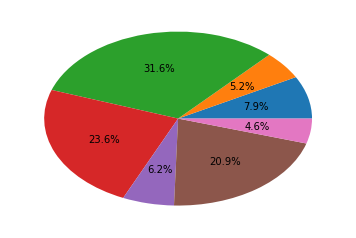

In [28]:
def numInY(Y):
    count_0 = 0
    count_1 = 0
    count_2 = 0
    count_3 = 0
    count_4 = 0
    count_5 = 0
    count_6 = 0
    for i in y:
        if i == 0:
            count_0 = count_0 + 1
        if i == 1:
            count_1 = count_1 + 1
        if i == 2:
            count_2 = count_2 + 1
        if i == 3:
            count_3 = count_3 + 1
        if i == 4:
            count_4 = count_4 + 1
        if i == 5:
            count_5 = count_5 + 1
        if i == 6:
            count_6 = count_6 + 1
    return [count_0, count_1, count_2, count_3, count_4, count_5, count_6] 
            
plt.pie(x=numInY(y),autopct='%1.1f%%')

As we can see, there is a massive class imbalance, where two classes alone make up over 50% of the data itself. In order to maintain even class division, any form of cross validation we choose will have to stratify the data. Otherwise we may get entire sets of data that only contain one class. This could skew our model’s training to just recognize everything as a single class, as in a fold of the data with only one class, this would be the most correct assumption. We also have another issue; since, the individual songs are grouped together by artist, we could get folds that have a dispositional amount of songs by the same artist in one genre. Band A and Band B may both be Genre C but have different sounding songs. We do not want a model only trained to recognize Band A as Genre C. In order to combat this, we must also shuffle the data in our cross validation. For these reasons, we are using a stratified shuffle split. This is an accurate reflection of real world test cases, where both a variety of songs from different artist and different genres will be tested against the model. Music streaming services are constantly getting new songs from new artist from a wide variety of different genres. However, some genres are more popular than others and therefore will have more songs belonging to them. This is bias towards genres is reflected in the stratification of the model’s folds. Musicians across the globe are able to produce and submit songs to music streaming services. These musicians while working in the same genre will not have same influences and could produce songs of the same genre that do not exactly like one another. To reflect the difference is artist, we shuffle the data, ensuring no fold is too focused on one specific artist’s definition of a genre. 
     


In [29]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
cv = StratifiedShuffleSplit(n_splits=10, random_state=1) 

In [ ]:
class MultiLayerPerceptronBase(object):
    def __init__(self, layers=2, phi='linear', cost_fn='quadratic', n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.layers=layers
        self.phi = phi
        self.cost_fn = cost_fn
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta

    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T

        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        weights = []
        W1_num_elems = (self.n_features_ + 1) * self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1)  # reshape to be W
        weights.append(W1)
        for i in range(1, self.layers):
            W_num_elems = (self.n_hidden + 1) * self.n_output_
            W = np.random.uniform(-1.0, 1.0, size=W_num_elems)
            W = W.reshape(self.n_output_, self.n_hidden + 1)
            weights.append(W)
        return weights

    @staticmethod
    def _sigmoid(phi, z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        if phi == 'sigmoid':
            return expit(z)
        else:
            return z/np.linalg.norm(z)

    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new

    @staticmethod
    def _L2_reg(lambda_, weights):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_ / 2.0) * np.sqrt(sum(np.mean(weight[:, 1:] ** 2) for weight in weights))

    def _cost(self, A, Y_enc, weights):
        '''Get the objective function value'''
        if self.cost_fn == 'cross_entropy':
            cost = -np.mean(np.nan_to_num((Y_enc * np.log(A) + (1 - Y_enc) * np.log(1 - A))))
        else:
            cost = np.mean((Y_enc - A) ** 2)
        L2_term = self._L2_reg(self.l2_C, weights)
        return cost + L2_term

    def _feedforward(self, X, weights):
        """Compute feedforward step
        """
        A = []
        Z = []
        A1 = self._add_bias_unit(X, how='column')
        A1 = A1.T
        Z1 = weights[0] @ A1
        A.append(A1)
        Z.append(Z1)
        for i in range(1, len(weights)):
            A_new = self._sigmoid(self.phi, Z1)
            A_new = self._add_bias_unit(A_new, how='row')
            Z_new = weights[i] @ A_new
            A.append(A_new)
            Z.append(Z_new)
        A_final = self._sigmoid(self.phi, Z[-1])
        A.append(A_final)
        return A, Z

    def _get_gradient(self, A, Z, Y_enc, weights):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        gradients = []
        if self.cost_fn == 'cross_entropy':
            V2 = (A[-1] - Y_enc)
        else:
            V2 = -2 * (Y_enc - A[2]) * A[2] * (1 - A[2])  # last layer sensitivity
        V1 = A[1] * (1 - A[1]) * (weights[1].T @ V2)  # back prop the sensitivity

        grad2 = V2 @ A[1].T  # no bias on final layer
        grad1 = V1[1:, :] @ A[0].T  # dont back prop sensitivity of bias

        gradients.append(grad1)
        gradients.append(grad2)
        # regularize weights that are not bias terms
        for weight_index in range(0, len(gradients)):
            gradients[weight_index][:, 1:] += weights[weight_index][:, 1:] * self.l2_C

        return gradients

    def predict(self, X):
        """Predict class labels"""
        A, Z = self._feedforward(X, self.weights)
        y_pred = np.argmax(A[-1], axis=0)
        return y_pred

# just start with the vectorized version and minibatch
class MLP(MultiLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True,
                 minibatches=1, **kwds):
        # need to add to the original initializer
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)

    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)

        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.weights = self._initialize_weights()

        delta_weights_prev =  [np.zeros(weight.shape) for weight in self.weights]

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data, self.predict(X_data)))
        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const * i)

            if print_progress > 0 and (i + 1) % print_progress == 0:
                sys.stderr.write('\rEpoch: %d/%d' % (i + 1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:
                # feedforward
                A, Z = self._feedforward(X_data[idx],self.weights)

                cost = self._cost(A[-1], Y_enc[:, idx], self.weights)
                mini_cost.append(cost)  # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradients = self._get_gradient(A=A, Z=Z, Y_enc=Y_enc[:, idx],
                                                  weights=self.weights)

                # momentum calculations
                delta_weights = [self.eta * grad for grad in gradients]
                for weight_index in range(0, len(self.weights)):
                    self.weights[weight_index] -= (delta_weights[weight_index] + (self.alpha * delta_weights_prev[weight_index]))
                delta_weights_prev = delta_weights

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data, self.predict(X_data)))

        return self